# Генетические алгоритмы для определения оптимального маршрута погрузки контейнера на поезд

In [95]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

Файл формата geoJSON содержит данные по точкам где могут быть контейнеры под погрузку и поезд. Для получения файла использовался сервис https://geojson.io/ 

In [96]:
zone = gpd.read_file('./data/containers_zone.json')
zone.head(6)

,marker-color,num,geometry
0,#e81717,1,POINT (30.35992 59.96832)
1,#05f521,1,POINT (30.36156 59.96800)
2,#e81717,2,POINT (30.36001 59.96828)
3,#05f521,2,POINT (30.36220 59.96771)
4,#e81717,3,POINT (30.36011 59.96824)
5,#05f521,3,POINT (30.36176 59.96791)


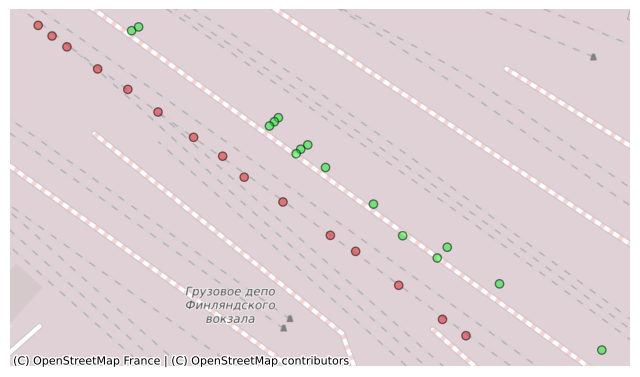

In [102]:
fig, ax = plt.subplots(figsize=(8, 8))
zone.to_crs(epsg=3857).plot(
    ax=ax, 
    alpha=0.5, 
    edgecolor='k', 
    color=zone['marker-color'],
)
ctx.add_basemap(
    ax=ax, 
    zoom=18, 
    source=ctx.providers.OpenStreetMap.France
)
ax.axis('off');

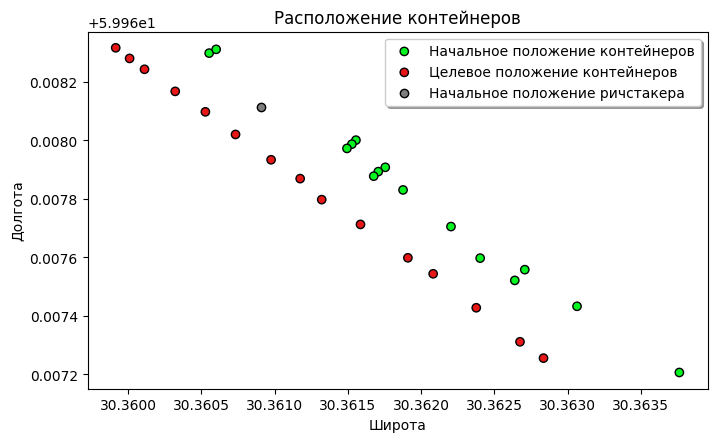

In [105]:
mask = zone['marker-color'] == '#05f521'
initial, target = zone[mask], zone[~mask]

fig, ax = plt.subplots(figsize=(8, 8))

ax.set(
    title = 'Расположение контейнеров',
    xlabel = 'Широта',
    ylabel = 'Долгота',
)

initial.plot(
    ax=ax,
    figure=fig, 
    color=initial['marker-color'],
    edgecolor='k',
    label='Начальное положение контейнеров'
)
target.plot(
    ax=ax,
    figure=fig, 
    color=target['marker-color'],
    edgecolor='k', 
    label='Целевое положение контейнеров'
)

d = {
    'marker-color': ['#7e7e7e'], 
    'num': [0], 
    'geometry': [Point(30.36090810069993, 59.9681123344929)]
}
richstacker = gpd.GeoDataFrame(d, crs="EPSG:4326")

richstacker.plot(
    ax=ax,
    figure=fig, 
    color=gdf['marker-color'],
    edgecolor='k',
    label='Начальное положение ричстакера'
)

ax.legend(shadow = True)